In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot



from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.datasets import load_svmlight_file
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.externals import joblib
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.externals import joblib
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
import time, os, random, sys
import math
import hyperopt.tpe
import hpsklearn.components
import hpsklearn.demo_support
import warnings

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1500)

warnings.filterwarnings('ignore')
random.seed(1)

/Users/garb47/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/garb47/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


In [44]:

def get_leaf_indices(ensemble, x):
    x = x.astype(np.float32)
    trees = ensemble.estimators_
    n_trees = trees.shape[0]
    indices = []

    for i in range(n_trees):
        tree = trees[i][0].tree_
        indices.append(tree.apply(x))

    indices = np.column_stack(indices)
    return indices


In [45]:
example = pd.read_csv('example2.csv')

In [46]:
train_df, test_df = train_test_split(example, train_size = 0.8)
X_train = train_df.drop([ 'Grant.Status'], axis=1)
y_train = train_df['Grant.Status']
X_test = test_df.drop([ 'Grant.Status'], axis=1)
y_test = test_df['Grant.Status']

In [47]:
gbclf = GradientBoostingClassifier()
gbclf.fit(X_train,y_train)
leaf = get_leaf_indices


In [48]:
X_train_leaves_1=leaf(gbclf,X_train.values)
X_test_leaves=leaf(gbclf,X_test.values)

In [31]:
X_train_leaves_1

array([[ 6,  6,  3, ...,  3,  3,  3],
       [11, 10, 11, ...,  3,  6,  3],
       [ 6,  6,  3, ...,  3,  3,  3],
       ..., 
       [ 6,  6,  4, ...,  3,  6,  3],
       [14, 14, 14, ...,  3,  6,  3],
       [ 7,  7,  7, ...,  3,  3,  3]])

In [63]:
lr = LogisticRegression()
lr.fit(X_train_leaves_1, y_train)
y_pred_gbdtlr1 = lr.predict_proba(X_test_leaves)[:,1]
gbdtlr_auc1 = roc_auc_score(y_test, y_pred_gbdtlr1)
print('gbdt+lr auc 1: %.5f' % gbdtlr_auc1)

gbdt+lr auc 1: 0.94661


In [33]:
X_train_leaves_2=gbclf.apply(X_train)[:,:,0]
X_test_leaves=gbclf.apply(X_test)[:,:,0]
X_train_leaves_2

array([[  6.,   6.,   3., ...,   3.,   3.,   3.],
       [ 11.,  10.,  11., ...,   3.,   6.,   3.],
       [  6.,   6.,   3., ...,   3.,   3.,   3.],
       ..., 
       [  6.,   6.,   4., ...,   3.,   6.,   3.],
       [ 14.,  14.,  14., ...,   3.,   6.,   3.],
       [  7.,   7.,   7., ...,   3.,   3.,   3.]])

In [42]:
X_train_leaves_3= gbclf.apply(X_train)
X_train_leaves_3.shape

(6966, 100, 1)

In [38]:
print(X_train_leaves_1.shape)
print(X_train_leaves_2.shape)
print(X_train_leaves_1.dtype)
X_train_leaves_2.dtype

(6966, 100)
(6966, 100)
int64


dtype('float64')

In [35]:
print(len(X_train_leaves))
print(len(X_train_leaves[0]))
y_pred_gbdtlr1 = lr.predict(X_test_leaves)
gbdtlr_auc1 = roc_auc_score(y_test, y_pred_gbdtlr1)
print('gbdt+lr auc 1: %.5f' % gbdtlr_auc1)

6966
100
gbdt+lr auc 1: 0.86089


In [230]:
gbc=GradientBoostingClassifier()
gbc.fit(X_train,y_train)
y_pred=gbc.predict_proba(X_test)[:,1]
auc=roc_auc_score(y_test,y_pred)
print(auc)

0.926577662934


In [102]:
xgb=XGBClassifier()
xgb.fit(X_train,y_train)
y_pred_xgb=xgb.predict_proba(X_test)[:,1]
auc=roc_auc_score(y_test,y_pred_xgb)
print(auc)

0.937434089492


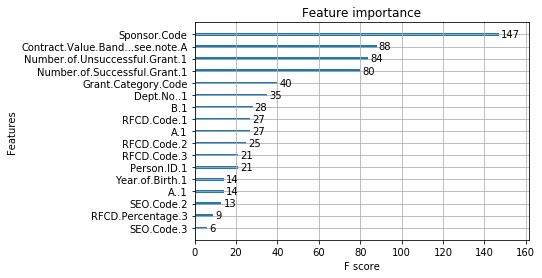

In [217]:
plot_importance(xgb)
pyplot.show()

In [49]:
train_rows = X_train_leaves_1.shape[0]
gbdtenc = OneHotEncoder()
X_trans = gbdtenc.fit_transform(np.concatenate((X_train_leaves_1, X_test_leaves), axis=0))

#GBDT+LR
lr = LogisticRegression()
lr.fit(X_trans[:train_rows,:], y_train)
y_pred_gbdtlr1 = lr.predict(X_trans[train_rows:,:])
gbdtlr_auc1 = roc_auc_score(y_test, y_pred_gbdtlr1)
print('GBDT + LR AUC 1: %.5f' % gbdtlr_auc1)


GBDT + LR AUC 1: 0.87732


In [51]:
X_trans[:train_rows,:].shape

(6966, 795)

In [54]:
y_pred=gbclf.apply(X_train)[:,:,0]
y_pred=y_pred.astype(np.int64)
num_leaf= np.max(y_pred)
X_train_leaves_gbc = np.zeros([len(y_pred),len(y_pred[0]) * num_leaf],dtype=np.int64)
for i in range(0,len(y_pred)):
    temp = np.arange(len(y_pred[0])) * num_leaf - 1 + np.array(y_pred[i])
    X_train_leaves_gbc[i][temp] += 1



In [55]:
X_train_leaves_gbc.shape

(6966, 1400)

In [56]:
y_pred=gbclf.apply(X_test)[:,:,0]
y_pred=y_pred.astype(np.int64)

X_test_leaves_gbc = np.zeros([len(y_pred),len(y_pred[0]) * num_leaf],dtype=np.int64)
for i in range(0,len(y_pred)):
    temp = np.arange(len(y_pred[0])) * num_leaf - 1 + np.array(y_pred[i])
    X_test_leaves_gbc[i][temp] += 1


In [60]:
lr.fit(X_train_leaves_gbc, y_train)
y_pred_gbdtlr1 = lr.predict(X_test_leaves_gbc)
gbdtlr_auc1 = roc_auc_score(y_test, y_pred_gbdtlr1)
print('gbdt+lr auc 1: %.5f' % gbdtlr_auc1)

gbdt+lr auc 1: 0.87732
